# Forecasting electricity demand with Python

Dette dokument følge denne guide: https://cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html

## Libraries

The libraries used in this document are:

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Helligdage
#===============================================================================
from datetime import date
import holidays

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

## Data

Dataen anvendt i dette dokument er blevet indhentet fra EnergiDataService.dk og DMI.dk. Datasættet indholder 3 kolonner and 159.767 observationer. Informationen for hver kolonne er:

* HourDK: Dato og tidspunkt for observationen.

* GrossConsumptionMWh: Energiforbrug (MW).

* temp_max_past1h: gennemsnits temperatur for hele landet (DK).

In [2]:
# Indlæsning af data
Data = pd.read_csv("C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Speciale/Data/Forbrug og Vejr Data.csv")

# Vælg kun nødvendige kolonner og kopier DataFrame
Forbrug_og_temp = Data[['HourDK', 'GrossConsumptionMWh', 'temp_max_past1h']].copy()

# Konverter 'HourDK' til datetime format og sæt som index
Forbrug_og_temp['HourDK'] = pd.to_datetime(Forbrug_og_temp['HourDK'])
Forbrug_og_temp.set_index('HourDK', inplace=True)

Forbrug_og_temp

,GrossConsumptionMWh,temp_max_past1h
HourDK,,
2005-01-01 00:00:00,3237.832763,2.350000
2005-01-01 01:00:00,3101.580811,2.134545
2005-01-01 02:00:00,2963.392211,2.023636
2005-01-01 03:00:00,2854.805420,2.066667
2005-01-01 04:00:00,2838.514649,1.954545
...,...,...
2023-05-30 17:00:00,3935.964505,16.416364
2023-05-30 18:00:00,3764.163099,15.803704
2023-05-30 19:00:00,3655.639568,15.183333


Dette datasæt laves nu til en tidsserie:

In [3]:
# Fylder manglende værdier
Forbrug_og_temp = Forbrug_og_temp.resample('H').asfreq()

# Erstat manglende værdier med interpolation
Forbrug_og_temp.interpolate(method='linear', inplace=True)

Forbrug_og_temp=Forbrug_og_temp[:len(Forbrug_og_temp)-22]

#Tilføjer helligdage til dataframen
dk_holidays = holidays.DK(years=range(2005, 2024))
# Vi skaber en ny kolonne, der markerer om dagen i hver time er en helligdag
dk_holidays_dates = [date for date in dk_holidays.keys()]
Forbrug_og_temp['Holiday'] = [1 if d in dk_holidays_dates else 0 for d in Forbrug_og_temp.index.date]

Forbrug_og_temp

,GrossConsumptionMWh,temp_max_past1h,Holiday
HourDK,,,
2005-01-01 00:00:00,3237.832763,2.350000,1
2005-01-01 01:00:00,3101.580811,2.134545,1
2005-01-01 02:00:00,2963.392211,2.023636,1
2005-01-01 03:00:00,2854.805420,2.066667,1
2005-01-01 04:00:00,2838.514649,1.954545,1
...,...,...,...
2023-05-29 19:00:00,3644.378019,12.391071,1
2023-05-29 20:00:00,3452.577998,11.371698,1
2023-05-29 21:00:00,3271.591882,10.537736,1


Datasættet starter den *2005-01-01 00:00:00* og slutter den *2023-05-30 21:00:00*. De sidste 22 observationer skæres fra så datasættet starter den *2005-01-01 00:00:00* og slutter den *2023-05-29 23:00:00*. Her efter vil datasætet splittes op i 3 sæt, træning, validering og test for at optimere hyperparameter for modellen og evaluere deres forudsigelses evner.

In [4]:
# Split data into train-val-test
# ==============================================================================
data = Forbrug_og_temp.loc['2005-01-01 00:00:00': '2023-05-29 23:00:00'].copy()
end_train = '2017-05-23 23:00:00'
end_validation = '2022-11-30 23:00:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2005-01-01 00:00:00 --- 2017-05-23 23:00:00  (n=108624)
Validation dates : 2017-05-23 23:00:00 --- 2022-11-30 23:00:00  (n=48409)
Test dates       : 2022-11-30 23:00:00 --- 2023-05-29 23:00:00  (n=4321)


## Graphic opdagelse

Når man bygger en forudsigelses model, kan det være brugbart at plotte tidsserien. Dette tillader mønstre såsom trend og seasonality at blive identificeret.

### Fulde tidsserie

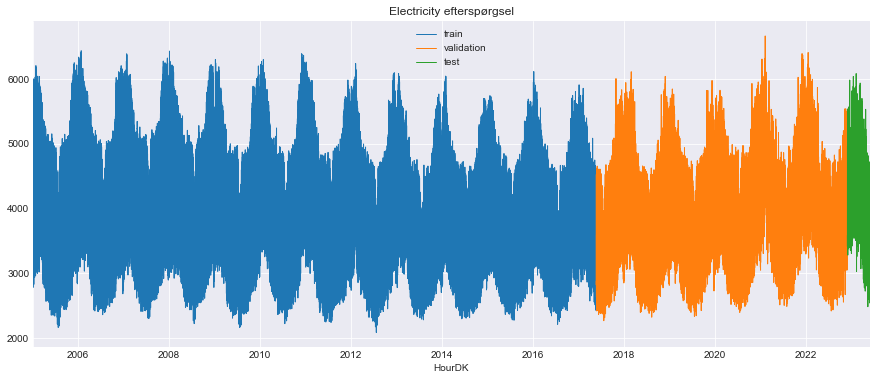

In [5]:
# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
data_train.GrossConsumptionMWh.plot(ax=ax, label='train', linewidth=1)
data_val.GrossConsumptionMWh.plot(ax=ax, label='validation', linewidth=1)
data_test.GrossConsumptionMWh.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Electricity efterspørgsel')
ax.legend();

Grafen ovenfor viser at energi efterspørgslen har en årlig seasonality. der er bunde i sommeren og toppe om vinteren.

### Sektion af tidserien

På grund af variansen af tidsserien er det ikke muligt at se de mulige daglige mønstre på et enkelt diagram.

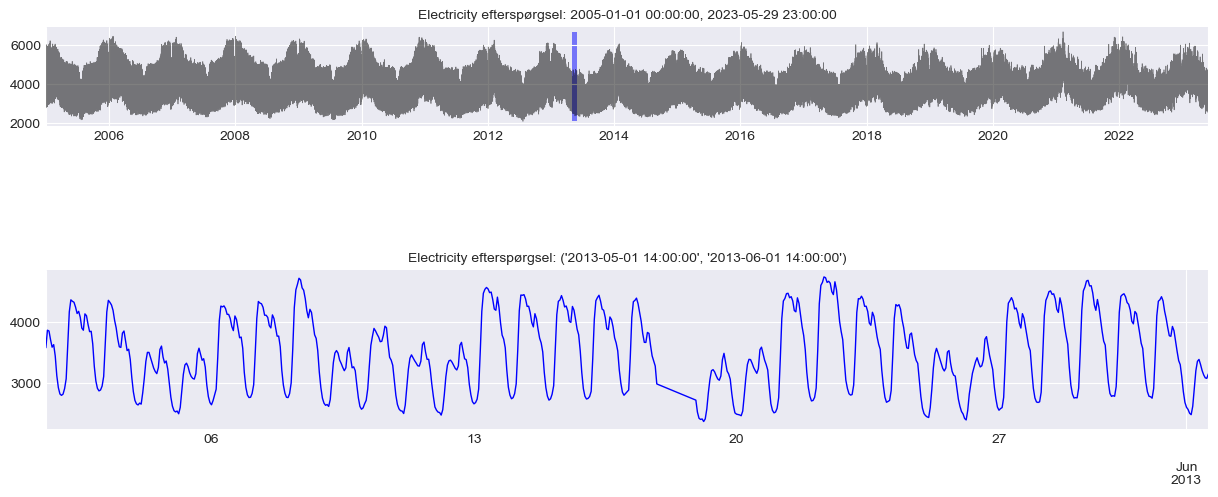

In [6]:
# Zooming time series chart
# ==============================================================================
zoom = ('2013-05-01 14:00:00','2013-06-01 14:00:00')
fig = plt.figure(figsize=(15, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)
main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])
data.GrossConsumptionMWh.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data.GrossConsumptionMWh)
max_y = max(data.GrossConsumptionMWh)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
data.loc[zoom[0]: zoom[1]].GrossConsumptionMWh.plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Electricity efterspørgsel: {data.index.min()}, {data.index.max()}', fontsize=10)
zoom_ax.set_title(f'Electricity efterspørgsel: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)

Når tidsserien er zoomet ind på, er det tydeligt at der også er en ugentlig seasonality, med højere forbrug i løbet af arbejdsdagene (mandag til fredag) og lavere forbrug i weekenderne. Der er også en klar correlation mellem forbruget på en dag og dagen før.

### Årlig, ugentlig og daglig seasonality

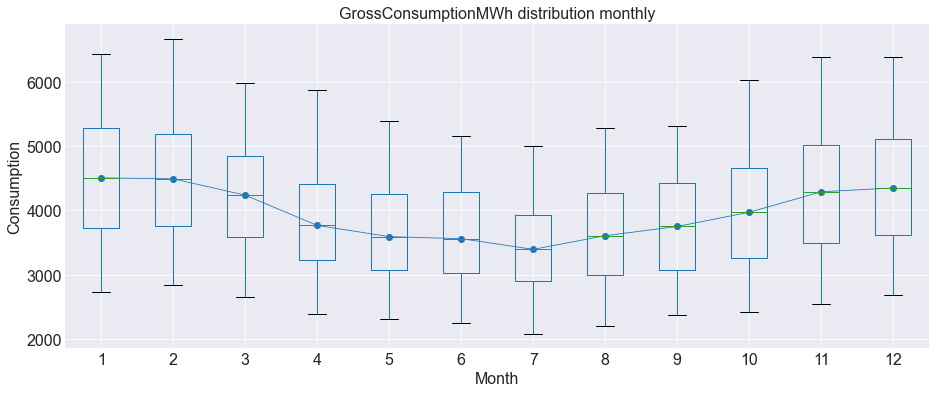

In [13]:
# Boxplot for annual seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
data['month'] = data.index.month
data.boxplot(column='GrossConsumptionMWh', by='month', ax=ax,)
data.groupby('month')['GrossConsumptionMWh'].median().plot(style='o-', linewidth=0.8, ax=ax, fontsize=16)
ax.set_ylabel('Consumption' ,fontsize=16)
ax.set_xlabel('Month', fontsize=16)
ax.set_title('GrossConsumptionMWh distribution monthly', fontsize=16)
fig.suptitle('');

Der kan observeres at der er en årlig seasonality, med højere gennemsnitlig efterspørgse i november, december, januar og februar. og at der er ingen outliers.

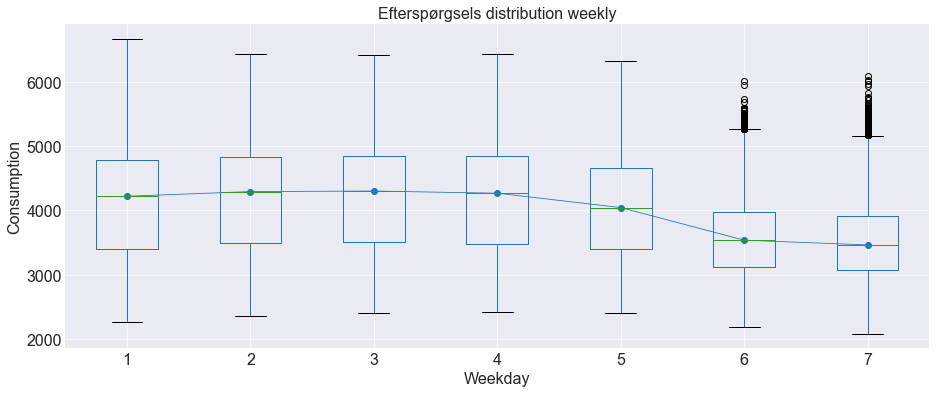

In [14]:
# Boxplot for weekly seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='GrossConsumptionMWh', by='week_day', ax=ax)
data.groupby('week_day')['GrossConsumptionMWh'].median().plot(style='o-', linewidth=0.8, ax=ax, fontsize=16)
ax.set_ylabel('Consumption', fontsize=16)
ax.set_xlabel('Weekday', fontsize=16)
ax.set_title('Efterspørgsels distribution weekly', fontsize=16)
fig.suptitle('');

Ugentlig seasonality viser lavere efterspørgsel i weekenden og med nogen outliers lørdag og søndag.

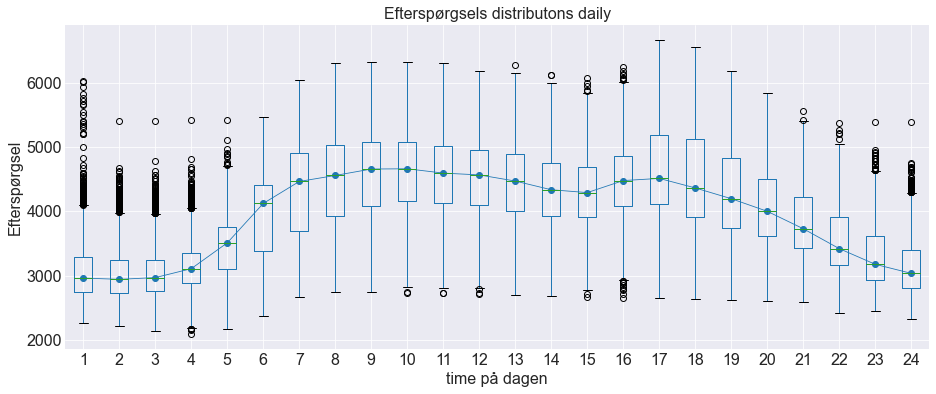

In [17]:
# Boxplot for daily seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
data['hour_day'] = data.index.hour + 1
data.boxplot(column='GrossConsumptionMWh', by='hour_day', ax=ax)
data.groupby('hour_day')['GrossConsumptionMWh'].median().plot(style='o-', linewidth=0.8, ax=ax,  fontsize=16)
ax.set_ylabel('consumption', fontsize=16)
ax.set_xlabel('', fontsize=16)
ax.set_title('Efterspørgsels distributons daily', fontsize=16)
fig.suptitle('');

Der er også daglig seasonality, med efterstpøsel stigende fra morgen og faldene mod eftermiddagen, og stiger igen ved en 17-18 tiden.

### Helligdage og ikke helligdage

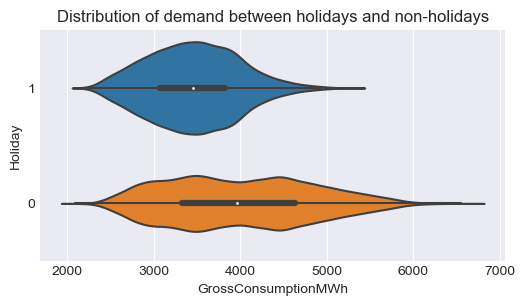

In [10]:
# Violinplot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
sns.violinplot(
    x       = 'GrossConsumptionMWh',
    y       = 'Holiday',
    data    = data.assign(Holiday = data.Holiday.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribution of demand between holidays and non-holidays')
ax.set_xlabel('GrossConsumptionMWh')
ax.set_ylabel('Holiday');

Forbruget ser ud til at være lavere på Helligdage.

### Autocorrelation plots

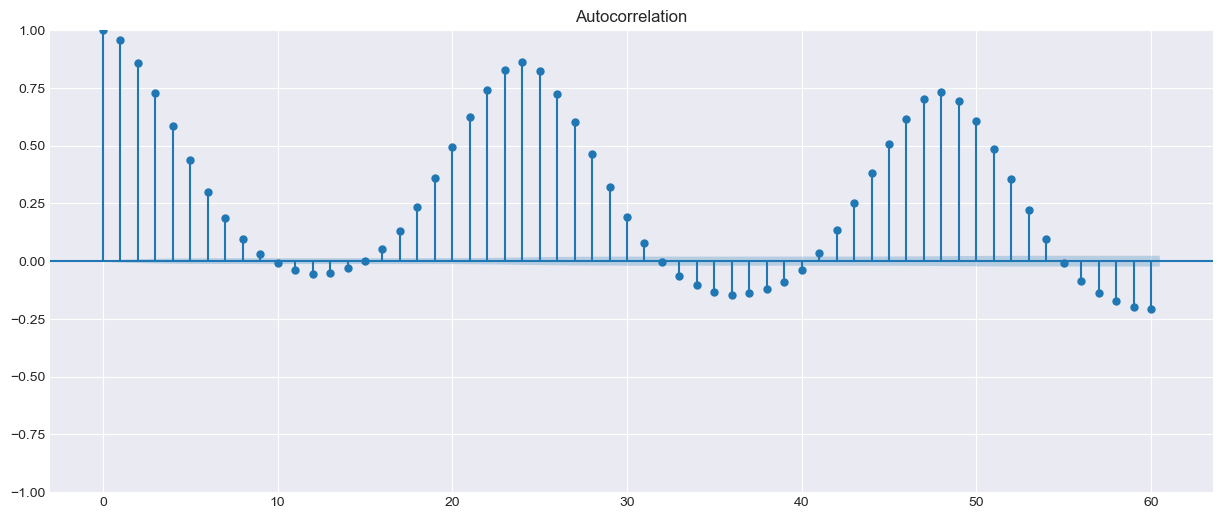

In [11]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(data.GrossConsumptionMWh, ax=ax, lags=60)
plt.show()

C:\Users\madsh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


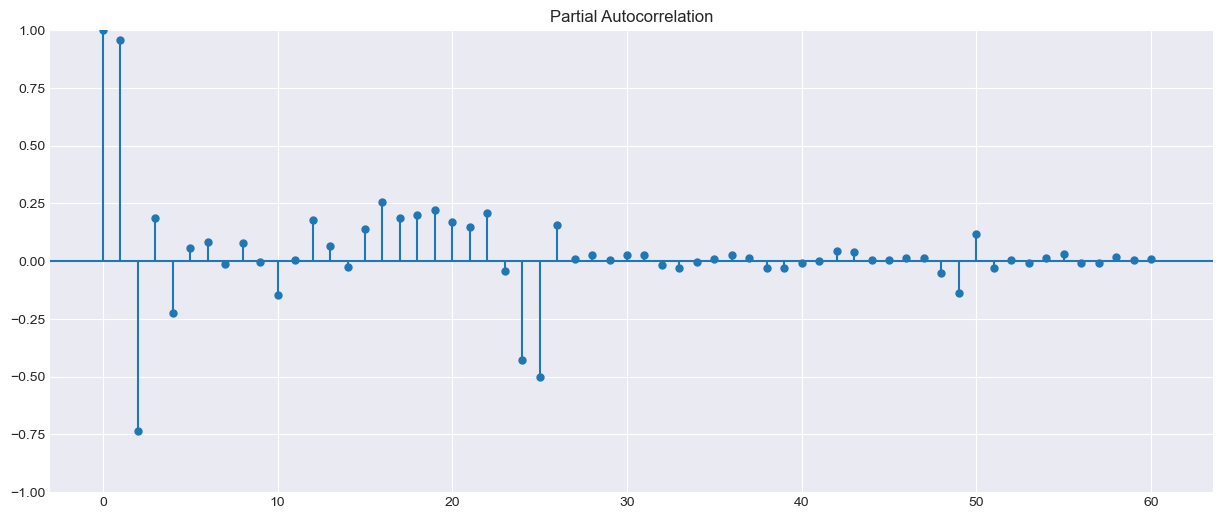

In [12]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(data.GrossConsumptionMWh, ax=ax, lags=60)
plt.show()

Auto correlationen og partielle autocorellatoin plotsne viser et klart forhold mellem efterspørgsel for en time og den tidligere, og mellem efterspørgslen for en time og den samme time den tidligere dag. Denne type autocorrelation er en indication på at autoregressive modeller kan virke godt. 

# Recursiv multi-step forudsigelse

En rekursiv autoregressions model (ForecasterAutoreg) is lavet og trænet fre en lineær regressions model med en Ridge penalty og et tidsvindue på 24 lags. Dette betyder at for hver forudsigelse, er efterspørgselsværdien for de tidligere 24 timer brugt som en prædikator. 

## Forecaster training

En StandardScaler er brugt som "data pre-processing transformation".

In [13]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24,
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=data.loc[:end_validation, 'GrossConsumptionMWh'])
forecaster

ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2005-01-01 00:00:00'), Timestamp('2022-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-07-12 02:55:49 
Last fit date: 2023-07-12 02:55:49 
Skforecast version: 0.9.0 
Python version: 3.9.7 
Forecaster id: None 

## Backtest

Den evaluere hvordan modellen har opført sig hvis den havde været trænet på data fra 2005-01-01 00:00:00 til 2023-05-29 23:00:00 og så hver dag klokken 23:00:00 forudsagde de næste 24 timer. Denne type evaluering, der hedder Backtesting, kan nemt implementeres med funktionen "backtesting_forcaster()". denne funktion retunere en fejl metric sammen med en forudsigelse.

In [14]:
# Backtest
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['GrossConsumptionMWh'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data.loc[:end_validation]),
                          refit              = False,
                          verbose            = True,
                          show_progress      = True
                    )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 157032
Number of observations used for backtesting: 4320
    Number of folds: 180
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2005-01-01 00:00:00 -- 2022-11-30 23:00:00  (n=157032)
    Validation: 2022-12-01 00:00:00 -- 2022-12-01 23:00:00  (n=24)
Fold: 1
    Training:   2005-01-01 00:00:00 -- 2022-11-30 23:00:00  (n=157032)
    Validation: 2022-12-02 00:00:00 -- 2022-12-02 23:00:00  (n=24)
Fold: 2
    Training:   2005-01-01 00:00:00 -- 2022-11-30 23:00:00  (n=157032)
    Validation: 2022-12-03 00:00:00 -- 2022-12-03 23:00:00  (n=24)
Fold: 3
    Training:   2005-01-01 00:00:00 -- 2022-11-30 23:00:00  (n=157032)
    Validation: 2022-12-04 00:00:00 -- 2022-12-04 23:00:00  (n=24)
Fold: 4
    Training:   2005-01-01 00:00:00 -- 2022-11-30 23:00:00  (n=157032)
    Validation: 20

  0%|          | 0/180 [00:00<?, ?it/s]

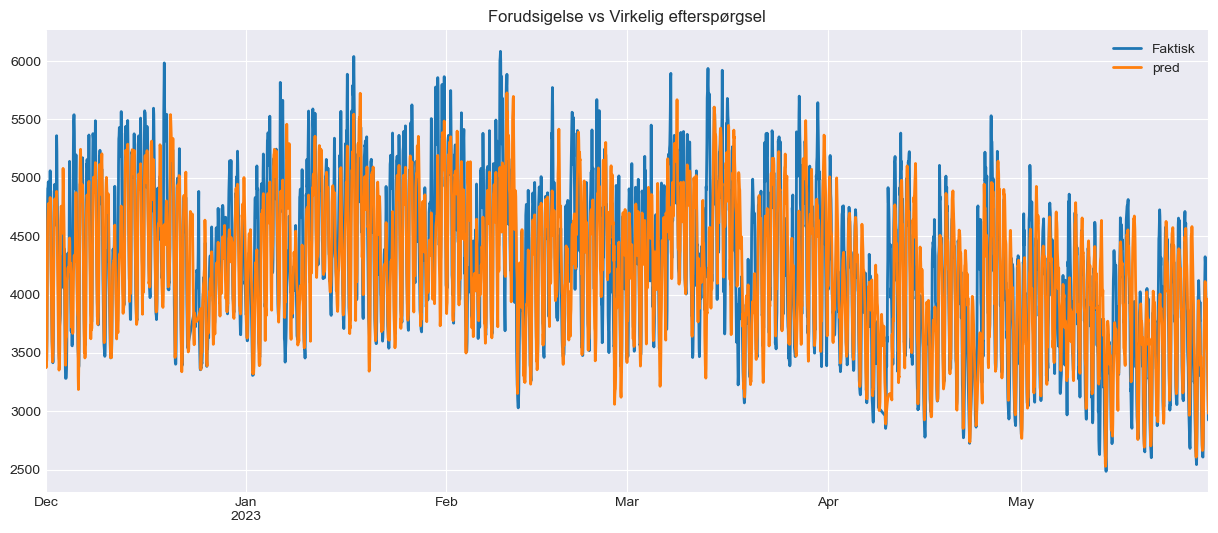

In [15]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
data.loc[predictions.index, 'GrossConsumptionMWh'].plot(ax=ax, linewidth=2, label='Faktisk')
predictions.plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('Forudsigelse vs Virkelig efterspørgsel')
ax.legend();

In [16]:
# Backtest error
# ==============================================================================
print(f'Backtest error: {metric}')

Backtest error: 296.6036508829404


## Hyperparameter tuning

Den trænede "ForecasterAutoreg" object bruger de første  24 lags og en ridge model med defualt hyperparametre. Der er dog ungen grund til at disse værdier skulle være de mest passende.

For at identificere den bedste combination af lags og hyperparameter er Grid Search med validering Backtesting brugt. Denne process består af at træne en model med forskellgie kombination af parametre og lags og så evaluere dens forudsigelses kapacitet. i denne søgnings proces er det vigtigt at evaluere modelen ved at bruge validerings data og ikke inkludere test data, som kun er brugt til at evaluere den endelige model.

In [17]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24, # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

# Lags used as predictors
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Regressor's hyperparameters
param_grid = {'alpha': np.logspace(-3, 5, 10)}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'GrossConsumptionMWh'],
                   steps              = 24,
                   metric             = 'mean_absolute_error',
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   initial_train_size = len(data[:end_train]),
                   refit              = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'alpha': 27.825594022071257}
  Backtesting metric: 234.07597495019434



In [18]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_absolute_error,alpha
25,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 27.825594022071257},234.075975,27.825594
24,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 3.593813663804626},234.251306,3.593814
23,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.46415888336127775},234.283423,0.464159
22,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.05994842503189409},234.287755,0.059948
21,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.007742636826811269},234.288316,0.007743
20,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.001},234.288389,0.001000
26,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 215.44346900318823},234.501319,215.443469
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.001},246.709151,0.001000
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.007742636826811269},246.709369,0.007743
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.05994842503189409},246.711059,0.059948


Det bedste resultat er fået ved at bruge lags [1, 2, 3, 23, 24, 25, 47, 48, 49] og en ridge configuration {'alpha': 27.825594022071257}. Ved at specificere "return_best = True" i "grid_search_forecaster()" funktionen. Forecaster objektet er automatisk re-trænet i slutningen af processen med den bedste configuration fundet og det fulle datasæt (træning+validering).

In [19]:
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=27.825594022071257, random_state=123) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2005-01-01 00:00:00'), Timestamp('2022-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 27.825594022071257, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-07-12 02:55:49 
Last fit date: 2023-07-12 02:57:32 
Skforecast version: 0.9.0 
Python version: 3.9.7 
Forecaster id: None 

## Backtest med test data

Når den bedste model er identificeret og trænet, kan der udregnes dens fejl i forudsigelse af data.

  0%|          | 0/180 [00:00<?, ?it/s]

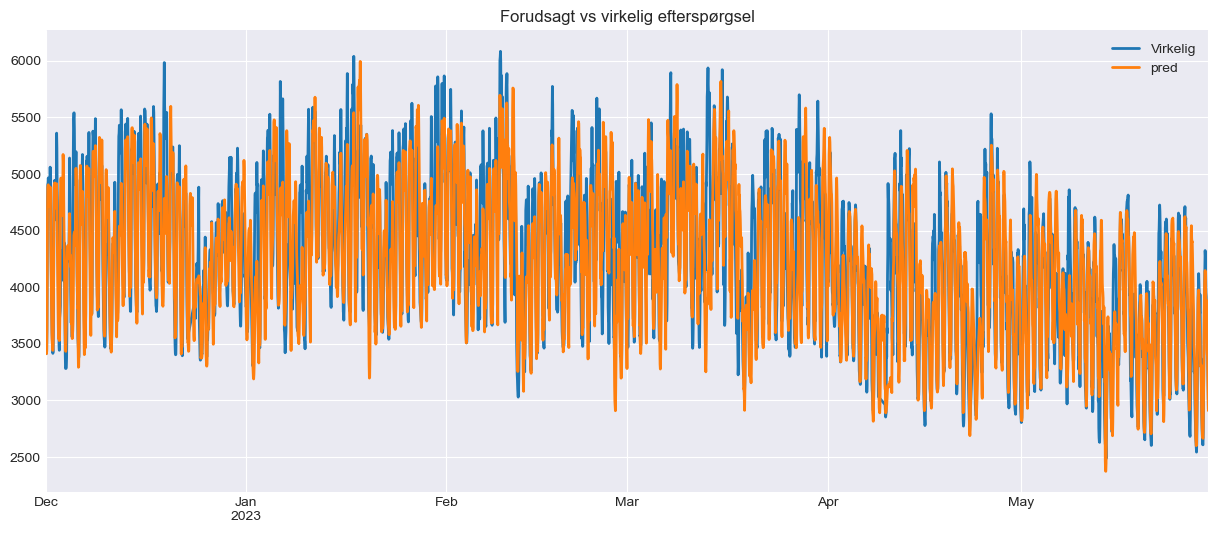

In [20]:
# Backtest final model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['GrossConsumptionMWh'],
                          steps              = 24,
                          metric             = mean_absolute_error,
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          verbose            = False,
                          show_progress      = True
                      )

fig, ax = plt.subplots(figsize=(15, 6))
data.loc[predictions.index, 'GrossConsumptionMWh'].plot(linewidth=2, label='Virkelig', ax=ax)
predictions.plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('Forudsagt vs virkelig efterspørgsel')
ax.legend();

In [21]:
# Backtest error
# ==============================================================================
print(f'Backtest error: {metric}')

Backtest error: 288.83973043029084


Efter optimering af lags og hyperparametre, reducerede vi fejlen fra 296.6 til 288.8

## Forudsigelsesinterval

En forudsigelsesinterval definerer intervallet, inden for hvilket den sande værdi af "y" kan forventes at findes med en given
sandsynlighed.

Rob J Hyndman og George Athanasopoulos, i deres bog "Forecasting: Principles and Practice", lister flere måder at estimere
forudsigelsesintervaller på, hvoraf de fleste kræver, at modellens residualer (fejl) er normalfordelte. Hvis dette ikke kan
antages, kan man ty til bootstrapping, som kun kræver, at resterne er ukorrelerede. Dette er metoden, der anvendes i 
**skforecast**-biblioteket.

In [22]:
# Backtest with test data and intervals
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = data['GrossConsumptionMWh'],
                          steps               = 24,
                          metric              = 'mean_absolute_error',
                          initial_train_size  = len(data.loc[:end_validation]),
                          refit               = False,
                          interval            = [10, 90],
                          n_boot              = 500,
                          in_sample_residuals = True,
                          verbose             = False,
                          show_progress       = True
                      )

print('Backtesting metric:', metric)
predictions.head(5)

  0%|          | 0/180 [00:00<?, ?it/s]

Backtesting metric: 288.83973043029084


,pred,lower_bound,upper_bound
2022-12-01 00:00:00,3488.995845,3400.466967,3573.467711
2022-12-01 01:00:00,3436.474319,3289.765092,3608.903142
2022-12-01 02:00:00,3411.608934,3221.490486,3634.035817
2022-12-01 03:00:00,3434.498251,3231.047474,3703.102180
2022-12-01 04:00:00,3649.284766,3422.083984,3978.517465


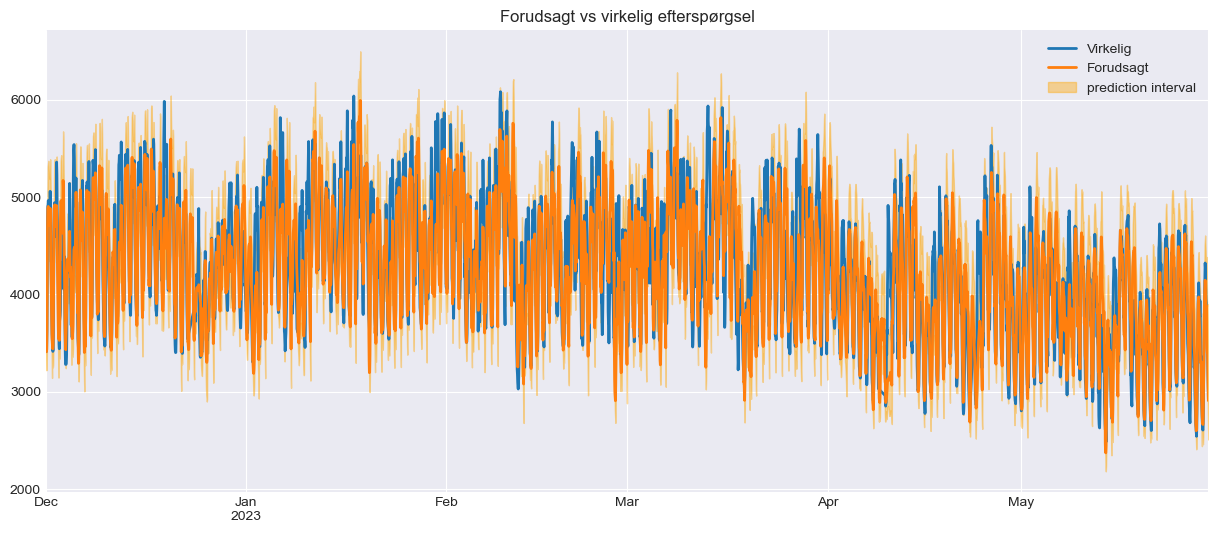

In [23]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
data.loc[predictions.index, 'GrossConsumptionMWh'].plot(linewidth=2, label='Virkelig', ax=ax)
predictions.iloc[:, 0].plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('Forudsagt vs virkelig efterspørgsel')
ax.fill_between(
    predictions.index,
    predictions.iloc[:, 1],
    predictions.iloc[:, 2],
    alpha = 0.4,
    color = 'orange',
    label = 'prediction interval' 
)
ax.legend();

In [24]:
inside_interval = np.where(
                      (data.loc[end_validation:, 'GrossConsumptionMWh'][1:] >= predictions["lower_bound"]) & \
                      (data.loc[end_validation:, 'GrossConsumptionMWh'][1:] <= predictions["upper_bound"]),
                      True,
                      False
                  )

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

Predicted interval coverage: 69.81 %


Dækningen af det forudsigede interval: 69,81 %
Det forudsigede interval har en lavere dækning end forventet (80 %). Dette kan skyldes, at modellen har en meget høj fejl for dagene i december. Disse dage falder inden for juleferieperioden, der normalt er præget af en anderledes forbrugeradfærd end resten af måneden.

## Forventet daglig prognose

Indtil nu er modellen blevet evalueret under antagelsen om, at prognoserne for næste dag køres umiddelbart efter den foregående dag. I praksis er dette ikke særlig nyttigt, da der ikke er tid til at håndtere de første timer af den næste dag.

Lad os nu antage, at prognoserne for den følgende dag skal foretages kl. 11:00 hver dag for at have tilstrækkelig fleksibilitet. Dette betyder, at kl. 11:00 på dag **D** skal du prognosticere timerne [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] af samme dag og timerne [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] af dag **D+1**. Dette betyder, at der skal forudsiges i alt 36 timer fremad, selvom kun de sidste 24 timer skal gemmes.

Denne type evaluering kan udføres ved hjælp af funktionen `backtesting_forecaster()` og dens `gap`-parameter. Derudover tillader parameteren `allow_incomplete_fold`, at den sidste fold udelades fra analysen, hvis den ikke har samme størrelse som det krævede antal trin. Processen, der er tilpasset dette scenarie, køres dagligt og består af følgende trin:

1. Kl. 11:00 på den første dag i testmængden forudsiges de næste 36 timer (de resterende 12 timer af dagen plus 24 timer af den følgende dag).
2. Kun prognoserne for næste dag gemmes, det vil sige fra position 12 og fremefter.
3. Den næste dag indtil kl. 11:00 tilføjes til testmængden.
4. Processen gentages.

Således har modellen kl. 11:00 hver dag adgang til de faktiske efterspørgselsværdier, der er registreret indtil det tidspunkt. 

In [25]:
# End of initial_train_size + 12 positions
# ==============================================================================
data.iloc[:len(data.loc[:end_validation])+12].tail(2)

,GrossConsumptionMWh,temp_max_past1h,Holiday,month,week_day,hour_day
HourDK,,,,,,
2022-12-01 10:00:00,4921.948608,2.75500,0,12,4,11
2022-12-01 11:00:00,4844.038086,3.04918,0,12,4,12


In [26]:
# Backtesting with gap
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['GrossConsumptionMWh'],
                          steps                 = 24,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data.loc[:end_validation])+12,
                          gap                   = 12,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          verbose               = True,
                          show_progress         = True  
                      )

print("")
print('Backtesting metric:', metric)
predictions.head(5)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 157044
Number of observations used for backtesting: 4308
    Number of folds: 179
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 12

Fold: 0
    Training:   2005-01-01 00:00:00 -- 2022-12-01 11:00:00  (n=157044)
    Validation: 2022-12-02 00:00:00 -- 2022-12-02 23:00:00  (n=24)
Fold: 1
    Training:   2005-01-01 00:00:00 -- 2022-12-01 11:00:00  (n=157044)
    Validation: 2022-12-03 00:00:00 -- 2022-12-03 23:00:00  (n=24)
Fold: 2
    Training:   2005-01-01 00:00:00 -- 2022-12-01 11:00:00  (n=157044)
    Validation: 2022-12-04 00:00:00 -- 2022-12-04 23:00:00  (n=24)
Fold: 3
    Training:   2005-01-01 00:00:00 -- 2022-12-01 11:00:00  (n=157044)
    Validation: 2022-12-05 00:00:00 -- 2022-12-05 23:00:00  (n=24)
Fold: 4
    Training:   2005-01-01 00:00:00 -- 2022-12-01 11:00:00  (n=157044)
    Validation: 2

  0%|          | 0/179 [00:00<?, ?it/s]


Backtesting metric: 352.7408668715782


,pred
2022-12-02 00:00:00,3448.543962
2022-12-02 01:00:00,3401.498750
2022-12-02 02:00:00,3395.075780
2022-12-02 03:00:00,3433.012888
2022-12-02 04:00:00,3640.309797


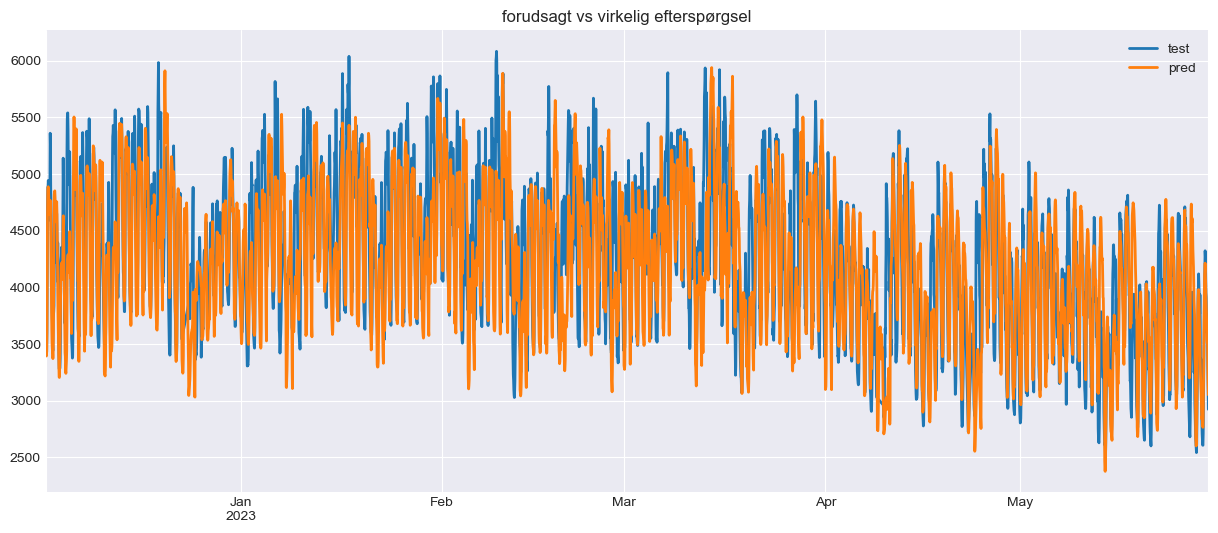

In [27]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
data.loc[predictions.index, 'GrossConsumptionMWh'].plot(linewidth=2, label='test', ax=ax)
predictions.plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('forudsagt vs virkelig efterspørgsel')
ax.legend();

In [28]:
# Backtest error
# ==============================================================================
error = mean_absolute_error(
            y_true = data.loc[predictions.index, 'GrossConsumptionMWh'],
            y_pred = predictions
        )
pct_error = ((np.sum(predictions).sum()-np.sum(data.loc[predictions.index, 'GrossConsumptionMWh']).sum())/np.sum(data.loc[predictions.index, 'GrossConsumptionMWh']).sum())*100
print(f"Backtest error: {error:.2f}", f"Backtest pct error: {pct_error:.2f}%")

Backtest error: 352.74 Backtest pct error: -1.19%


Da `ForecasterAutoreg` objektet bruger **scikit-learn** modeller, kan vigtigheden af prædiktorerne fås, når de er blevet trænet. Hvis regressoren, der anvendes, er en `LinearRegression()`, `Lasso()` eller `Ridge()`, afspejler koefficienterne for modellen deres vigtighed. I regressorerne `GradientBoostingRegressor()` eller `RandomForestRegressor` er vigtigheden af prædiktorerne baseret på usikkerheden.

In [29]:
# Predictors importance
# ==============================================================================
forecaster.get_feature_importances()

,feature,importance
0,lag_1,1.291404
1,lag_2,-0.432250
2,lag_3,0.102410
3,lag_23,0.136128
4,lag_24,0.353303
5,lag_25,-0.467493
6,lag_47,-0.016525
7,lag_48,0.156534
8,lag_49,-0.132924


# Forecasting with exogenous variables

I det tidligere eksempel blev der kun brugt forsinkelser af den forudsagte variabel som prædiktorer. I nogle scenarier er det muligt at have information om andre variable, hvis fremtidige værdi er kendt, og disse kan bruges som yderligere prædiktorer i modellen. Typiske eksempler er:

- Helligdage (lokale, nationale...)
- Måneden på året
- Ugedagen
- Tidspunktet på dagen

I dette brugstilfælde viste den grafiske analyse, at efterspørgslen er lavere på helligdage. Om en dag er en helligdag eller ej kan kendes på forhånd, så det kan bruges som en eksogen variabel. Se, hvordan det påvirker modellen, når variablen "Holiday", der er tilgængelig i datasættet, inkluderes som en prædiktor.


## Forecaster Training

De optimale hyperparametre og forsinkelser, der blev identificeret i den tidligere sektion, anvendes.

In [30]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = Ridge(alpha=215.44, random_state=123),
                 lags             = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                 transformer_y    = StandardScaler(),
                 transformer_exog = None
             )

forecaster.fit(y=data.loc[:end_validation, 'GrossConsumptionMWh'], exog=data.loc[:end_validation, 'Holiday'])
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=215.44, random_state=123) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: Holiday 
Training range: [Timestamp('2005-01-01 00:00:00'), Timestamp('2022-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 215.44, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-07-12 02:59:21 
Last fit date: 2023-07-12 02:59:21 
Skforecast version: 0.9.0 
Python version: 3.9.7 
Forecaster id: None 

## Forventet daglig prognose

Processen med backtesting med gap, hvor prognoserne for den følgende dag skal opnås kl. 11:00 hver dag, gentages. Denne gang inkluderes det som en prædiktor, om dagen er en helligdag eller ej.

In [31]:
# Backtest with gap
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['GrossConsumptionMWh'],
                          exog                  = data['Holiday'],
                          steps                 = 24,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data.loc[:end_validation])+12,
                          gap                   = 12,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          verbose               = False,
                          show_progress         = True  
                      )

  0%|          | 0/179 [00:00<?, ?it/s]

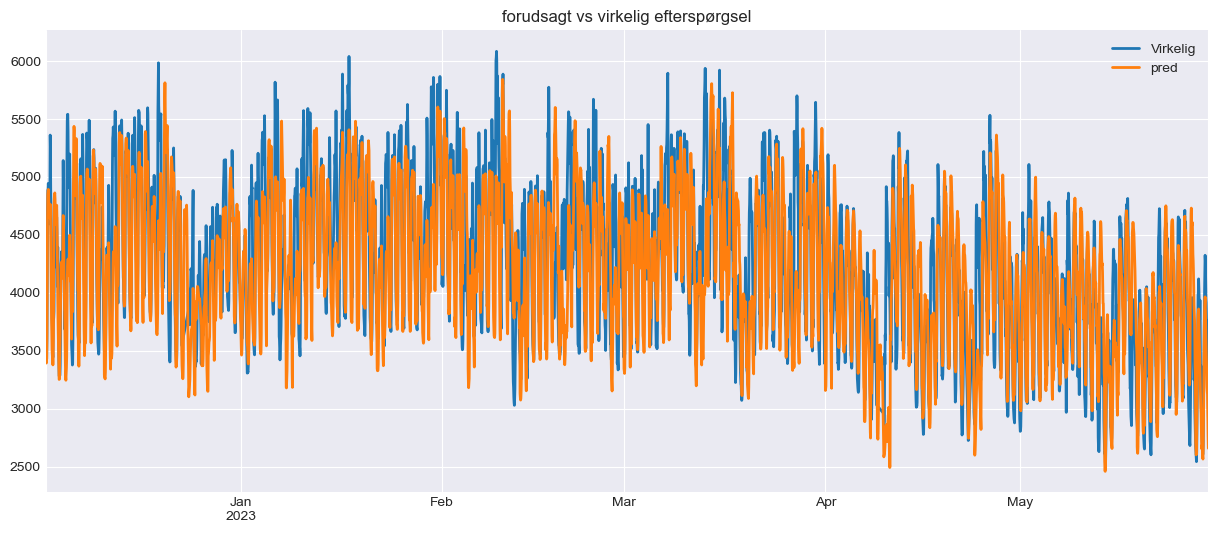

In [32]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
data.loc[predictions.index, 'GrossConsumptionMWh'].plot(linewidth=2, label='Virkelig', ax=ax)
predictions.plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('forudsagt vs virkelig efterspørgsel')
ax.legend();

In [33]:
# Backtest error
# ==============================================================================
error = mean_absolute_error(
            y_true = data.loc[predictions.index, 'GrossConsumptionMWh'],
            y_pred = predictions
        )
pct_error = ((np.sum(predictions).sum()-np.sum(data.loc[predictions.index, 'GrossConsumptionMWh']).sum())/np.sum(data.loc[predictions.index, 'GrossConsumptionMWh']).sum())*100
print(f"Backtest error: {error:.2f}", f"Backtest pct error: {pct_error:.2f}%")

Backtest error: 346.86 Backtest pct error: -1.56%


Ved at bruge om dagen er en helligdag eller ej som en eksogen variabel reduceres forudsætningsfejlen let fra 352.7 til 346.9. Lad os se, hvad der sker, når vi tilføjer som prædiktorer, om den foregående og den følgende dag er helligdage, ugedagen og tidspunktet på dagen.

In [34]:
# Creation of new exogenous variables
# ==============================================================================
# Since it is hourly data and starts at 00:00, the values must be shifted 
# by 24 hours
data['Holiday_day_before'] = data['Holiday'].shift(24)
data['Holiday_next_day']   = data['Holiday'].shift(-24)
data = data.dropna()

# One hot encoding of week_day and hour_day
# ==============================================================================
one_hot_encoder = make_column_transformer(
                        (
                            OneHotEncoder(sparse_output=False, drop='if_binary'),
                            ['week_day', 'hour_day'],
                        ),
                        remainder="passthrough",
                        verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

data = one_hot_encoder.fit_transform(data)
data.head(3)

,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6,week_day_7,hour_day_1,hour_day_2,hour_day_3,...,hour_day_21,hour_day_22,hour_day_23,hour_day_24,GrossConsumptionMWh,temp_max_past1h,Holiday,month,Holiday_day_before,Holiday_next_day
HourDK,,,,,,,,,,,,,,,,,,,,,
2005-01-02 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2925.896118,5.047170,0,1,1.0,0.0
2005-01-02 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,2828.778442,5.361818,0,1,1.0,0.0
2005-01-02 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,2788.279541,5.525455,0,1,1.0,0.0


In [35]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = Ridge(alpha=27.825594, random_state=123),
                 lags             = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                 transformer_y    = StandardScaler(),
                 transformer_exog = None
             )

exog = [col for col in data.columns if col.startswith(('week_day', 'hour', 'Holiday'))]
forecaster.fit(y=data.loc[:end_validation, 'GrossConsumptionMWh'], exog=data.loc[:end_validation, exog])

# Backtest with gap
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['GrossConsumptionMWh'],
                          exog                  = data[exog],
                          steps                 = 24,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data.loc[:end_validation])+12,
                          gap                   = 12,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          verbose               = False,
                          show_progress         = True  
                      )

# Backtest error
# ==============================================================================

error = mean_absolute_error(
            y_true = data.loc[predictions.index, 'GrossConsumptionMWh'],
            y_pred = predictions
        )
pct_error = ((np.sum(predictions).sum()-np.sum(data.loc[predictions.index, 'GrossConsumptionMWh']).sum())/np.sum(data.loc[predictions.index, 'GrossConsumptionMWh']).sum())*100
print("")
print(f"Backtest error: {error:.2f}", f"Backtest pct error: {pct_error:.2f}%")

  0%|          | 0/178 [00:00<?, ?it/s]


Backtest error: 310.10 Backtest pct error: -1.93%


De nye prædiktorer reducerer yderligere modelfejlen fra 346.9 til 310.1

## Inkluder temperatur som en prædikator

Da temperaturen også er tilgængelig i datasættet og er relateret til `GrossConsumptionMWh`, kan det være fristende at inkludere
det som en prædiktor. Dog **ville denne tilgang ikke være korrekt**, da den fremtidige temperatur er ukendt. Det er muligt at
bruge temperaturprognosen som en prædiktor for modellen, men i så fald skal modellen trænes på prognosetemperaturen, ikke den
faktiske temperatur.

# Direct multi-step forudsigelse

Modellerne `ForecasterAutoreg` og `ForecasterAutoregCustom` følger en rekursiv flertrinsstrategi, hvor hver ny prognose bygger
på den foregående. Et alternativ er at træne en model for hvert af de trin, der skal forudsiges. Denne strategi, kendt som
Direct multi-step forudsigelse er beregningsmæssigt mere krævende end den rekursive strategi, da den kræver træning af flere
modeller. Dog giver den i nogle scenarier bedre resultater. Denne type model kan opnås ved hjælp af `ForecasterAutoregDirect`.

## Forudsigelse træning og tuning

I modsætning til brugen af `ForecasterAutoreg` eller `ForecasterAutoregCustom`, skal antallet af trin, der skal forudsiges, angives ved initialiseringen af prognostikeren i `ForecasterAutoregDirect`-modeller.

In [36]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor        = LGBMRegressor(random_state=123),
                 steps            = 36, # Steps + gap
                 lags             = 24, # This value will be replaced in the grid search
                 transformer_y    = None,
                 transformer_exog = None
             )

# Lags used as predictors
lags_grid = [[1, 2, 3, 23, 24], [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [4, 6]}

results_grid = grid_search_forecaster(
                   forecaster            = forecaster,
                   y                     = data.loc[:end_validation, 'GrossConsumptionMWh'],
                   exog                  = data.loc[:end_validation, exog],
                   steps                 = 24,
                   metric                = 'mean_absolute_error',
                   param_grid            = param_grid,
                   lags_grid             = lags_grid,
                   initial_train_size    = len(data.loc[:end_train])+12,
                   gap                   = 12,
                   allow_incomplete_fold = True,
                   refit                 = False,
                   return_best           = True,
                   verbose               = False
               )

Number of models compared: 8.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'max_depth': 6, 'n_estimators': 500}
  Backtesting metric: 189.60489754753397



In [37]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_absolute_error,max_depth,n_estimators
7,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 6, 'n_estimators': 500}",189.604898,6,500
5,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 4, 'n_estimators': 500}",193.332488,4,500
3,"[1, 2, 3, 23, 24]","{'max_depth': 6, 'n_estimators': 500}",195.453895,6,500
6,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 6, 'n_estimators': 100}",197.414396,6,100
1,"[1, 2, 3, 23, 24]","{'max_depth': 4, 'n_estimators': 500}",197.867171,4,500
2,"[1, 2, 3, 23, 24]","{'max_depth': 6, 'n_estimators': 100}",203.435042,6,100
4,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 4, 'n_estimators': 100}",211.872831,4,100
0,"[1, 2, 3, 23, 24]","{'max_depth': 4, 'n_estimators': 100}",219.200823,4,100


## Forventet daglig forudsigelse

Processen med backtesting, inklusive de nye eksogene variable, gentages.

In [38]:
# Backtest with gap
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['GrossConsumptionMWh'],
                          exog                  = data[exog],
                          steps                 = 24,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data.loc[:end_validation])+12,
                          gap                   = 12,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          verbose               = False,
                          show_progress         = True  
                      )

  0%|          | 0/178 [00:00<?, ?it/s]

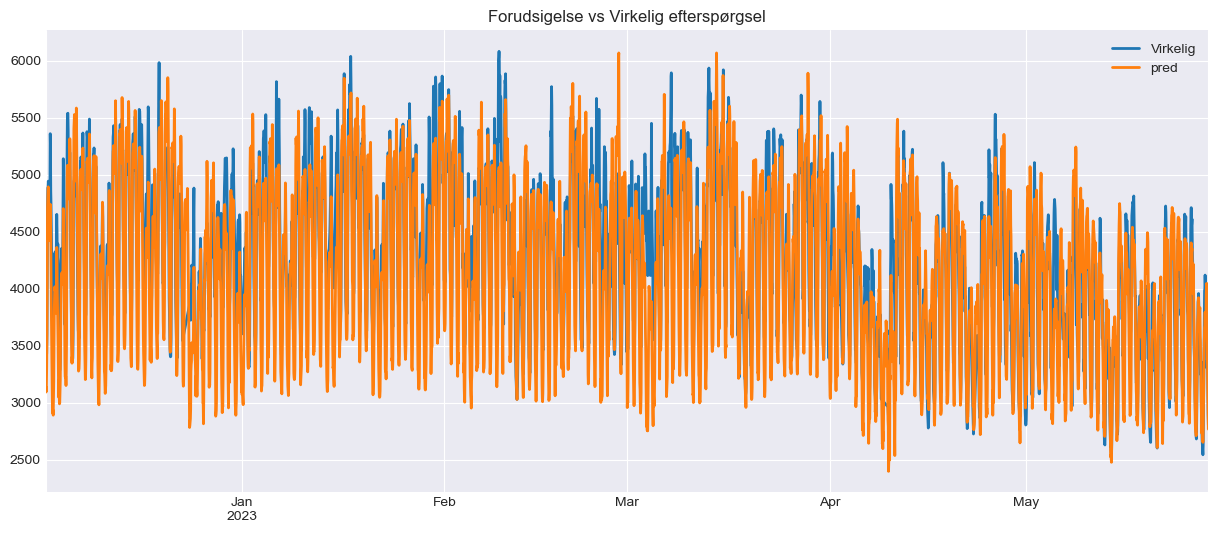

In [39]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15,6 ))
data.loc[predictions.index, 'GrossConsumptionMWh'].plot(linewidth=2, label='Virkelig', ax=ax)
predictions.plot(linewidth=2, label='Forudsigelse', ax=ax)
ax.set_title('Forudsigelse vs Virkelig efterspørgsel')
ax.legend();

In [40]:
# Backtest error
# ==============================================================================
error = mean_absolute_error(
            y_true = data.loc[predictions.index, 'GrossConsumptionMWh'],
            y_pred = predictions
        )
pct_error = ((np.sum(predictions).sum()-np.sum(data.loc[predictions.index, 'GrossConsumptionMWh']).sum())/np.sum(data.loc[predictions.index, 'GrossConsumptionMWh']).sum())*100
print(f"Backtest error: {error:.2f}", f"Backtest pct error: {pct_error:.2f}%")

Backtest error: 331.38 Backtest pct error: -2.85%


I dette tilfælde genererer den direkte flertrinsstrategi bedre resultater end den rekursive strategi med en lineær model, når der anvendes en Gradient Boosting LGBMRegressor-model.